<a href="https://www.kaggle.com/code/rubanzasilva/s04e05-fastai?scriptVersionId=180467173" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Regression with a Flood Prediction Dataset

Playground Series - Season 4, Episode 5 where we are tasked with predicting the likelihood of floods in certain areas based off various factors.

## Imports

Below, i import all the libraries and datasets needed for this competition.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flood-prediction-factors/flood.csv
/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


In [2]:
!pip install openfe

In [3]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

#from fastkaggle import setup_comp

import optuna
from openfe import OpenFE, transform

from IPython.display import FileLink



In [4]:
!ls /kaggle/input/playground-series-s4e5

sample_submission.csv  test.csv  train.csv


In [5]:
#set_seed(42)

In [6]:
path = Path('/kaggle/input/playground-series-s4e5/')
path

Path('/kaggle/input/playground-series-s4e5')

After some experimentation, i noticed adding the original dataset helps the model generalize better and produces better results.

In [7]:
!ls /kaggle/input/flood-prediction-factors

flood.csv


In [8]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')
original_df = pd.read_csv('/kaggle/input/flood-prediction-factors/flood.csv')

In [12]:
train_df.shape,original_df.shape,test_df.shape

((1117957, 21), (50000, 21), (745305, 20))

In [14]:
train_final = pd.concat([train_df,original_df], axis=0)
test_final = pd.concat([test_df,original_df],axis=0)
train_final.shape,test_final.shape

((1167957, 21), (795305, 21))

## Data Subset

In [11]:
train_subset = train_df.sample(n=200000,replace=False)
test_subset = test_df.sample(n=150000,replace=False)

In [12]:
train_subset.shape

(200000, 21)

# Initial Data Exploration

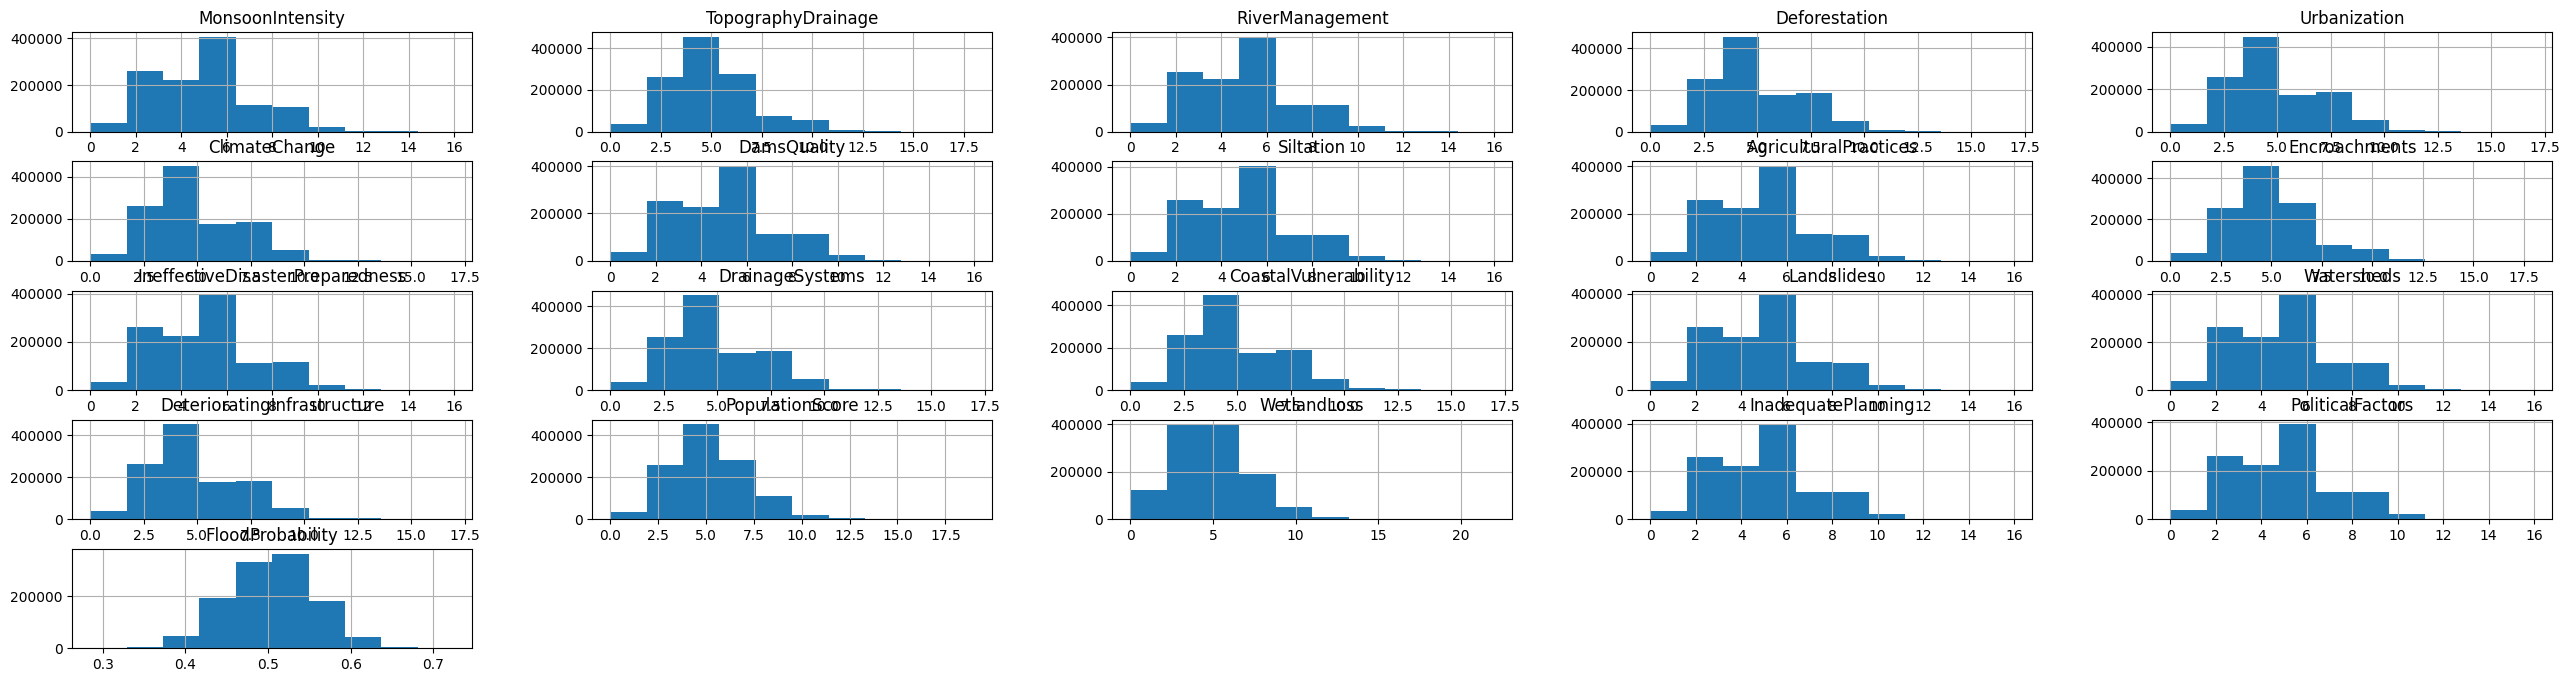

In [19]:
train_final.hist(figsize=(32,8));

# Baseline

This is a simple models with just the datasets provided excluding the original datasets and no extra feature engineering or feature transformatione except the defaults.

I will use random forests and neural networks as a baseline, usually i would use just the random forest since a neural network is more sensitive to parameter changes but for this case it seems to run faster, so i use i create 2 baselines.

Below i use the fastai cont_cat_split function to divide my columsn into categorical and continous variables.

# Without Original Dataset

In [ ]:
cont_names,cat_names = cont_cat_split(train_subset, dep_var='FloodProbability')

In [ ]:
cont_names,cat_names = cont_cat_split(train_subset, dep_var='FloodProbability')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_subset))
to = TabularPandas(train_subset, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_subset)

In [ ]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_subset))

In [ ]:
to = TabularPandas(train_subset, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [ ]:
baseline_dls = to.dataloaders(bs=64)
test_dl = baseline_dls.test_dl(test_subset)

### Random Forest

In [ ]:
%%time
rf = RandomForestRegressor(50, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

### Neural Network

In [ ]:
learn = tabular_learner(baseline_dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
%%time
learn.fit_one_cycle(12,0.02)

In [ ]:
dls = baseline_dls

In [ ]:
dl = learn.dls.test_dl(test_subset)

In [ ]:
%%time
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

In [ ]:
#dataset no original training subset without openFE features,trial 2
r2_score(y_test,nn_preds_x)

In [ ]:
#dataset no original training subset without openFE features
r2_score(y_test,nn_preds_x)

So our random forest returns an r2score of **0.6120240869172946** while our neural network returns a score of **0.8525719134742764** which we shall use as our baseline scores.

So from now on, our goal will be to try to improve this score.

### CatBoost

In [ ]:
cat_model = CatBoostRegressor(iterations=1500, depth=8, learning_rate= 0.012, random_strength=8)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

# Adding Original Dataset

In [11]:
train_final = pd.concat([train_df,original_df], axis=0)
test_final = pd.concat([test_df,original_df],axis=0)

In [16]:
cont_names,cat_names = cont_cat_split(train_final, dep_var='FloodProbability')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_final))
to = TabularPandas(train_final, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

In [ ]:
%%time
rf = RandomForestRegressor(50, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

In [ ]:
learn1 = tabular_learner(dls, metrics=R2Score())
learn1.lr_find(suggest_funcs=(slide,valley))

In [ ]:
%%time
learn1.fit_one_cycle(12,0.02)

In [ ]:
dl = learn1.dls.test_dl(test_subset)

In [ ]:
%%time
nn_preds = learn1.get_preds(dl=dl)
nn_preds_x = learn1.get_preds()[0]
a_preds, _ = learn1.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

In [ ]:
#dataset with original training subset with new openFE features
r2_score(y_test,nn_preds_x)

Random forest now scores **0.6504381557189793** while the neural network scores **0.8578640002891056** which is an improvement from our previous scores.

### CatBoost

In [17]:
cat_model = CatBoostRegressor(iterations=1500, depth=8, learning_rate= 0.012, random_strength=8)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

0.8391793273605473

We can conclude that adding the original dataset improves the model's results.

# Adding Base Features

from https://www.kaggle.com/code/trupologhelper/ps4e5-openfe-blending-explain#Creating-New-Features-%F0%9F%93%8A

In [20]:
BASE_FEATURES = test_final.columns
BASE_FEATURES

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')

In [21]:
#BASE_FEATURES = test.columns
def add_features(df):


    df['total'] = df[BASE_FEATURES].sum(axis=1)
    df['mean'] = df[BASE_FEATURES].mean(axis=1)
    df['std'] = df[BASE_FEATURES].std(axis=1)
    df['max'] = df[BASE_FEATURES].max(axis=1)
    df['min'] = df[BASE_FEATURES].min(axis=1)
    df['median'] = df[BASE_FEATURES].median(axis=1)
    df['ptp'] = df[BASE_FEATURES].values.ptp(axis=1)
    df['q25'] = df[BASE_FEATURES].quantile(0.25, axis=1)
    df['q75'] = df[BASE_FEATURES].quantile(0.75, axis=1)
    
    df['ClimateImpact'] = df['MonsoonIntensity'] + df['ClimateChange']
    df['AnthropogenicPressure'] = df['Deforestation'] + df['Urbanization'] + df['AgriculturalPractices'] + df['Encroachments']
    df['InfrastructureQuality'] = df['DamsQuality'] + df['DrainageSystems'] + df['DeterioratingInfrastructure']
    df['CoastalVulnerabilityTotal'] = df['CoastalVulnerability'] + df['Landslides']
    df['PreventiveMeasuresEfficiency'] = df['RiverManagement'] + df['IneffectiveDisasterPreparedness'] + df['InadequatePlanning']
    df['EcosystemImpact'] = df['WetlandLoss'] + df['Watersheds']
    df['SocioPoliticalContext'] = df['PopulationScore'] * df['PoliticalFactors']


    df['FloodVulnerabilityIndex'] = (df['AnthropogenicPressure'] + df['InfrastructureQuality'] +
                                     df['CoastalVulnerabilityTotal'] + df['PreventiveMeasuresEfficiency']) / 4
    
    df['PopulationDensityImpact'] = df['PopulationScore'] * (df['Urbanization'] + df['Encroachments'])
    
    df['DeforestationUrbanizationRatio'] = df['Deforestation'] / df['Urbanization']
    
    df['AgriculturalEncroachmentImpact'] = df['AgriculturalPractices'] * df['Encroachments']
    
    df['DamDrainageInteraction'] = df['DamsQuality'] * df['DrainageSystems']
    
    df['LandslideSiltationInteraction'] = df['Landslides'] * df['Siltation']
    
    df['WatershedWetlandRatio'] = df['Watersheds'] / df['WetlandLoss']
    
    df['PoliticalPreparednessInteraction'] = df['PoliticalFactors'] * df['IneffectiveDisasterPreparedness']
    
    
    df['TopographyDrainageSiltation'] = df['TopographyDrainage'] + df['Siltation']
    
    df['ClimateAnthropogenicInteraction'] = df['ClimateImpact'] * df['AnthropogenicPressure']
    
    df['InfrastructurePreventionInteraction'] = df['InfrastructureQuality'] * df['PreventiveMeasuresEfficiency']
    
    df['CoastalEcosystemInteraction'] = df['CoastalVulnerabilityTotal'] * df['EcosystemImpact']

    return df

train = add_features(train_final)
test = add_features(test_final)

In [22]:
train.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DeforestationUrbanizationRatio,AgriculturalEncroachmentImpact,DamDrainageInteraction,LandslideSiltationInteraction,WatershedWetlandRatio,PoliticalPreparednessInteraction,TopographyDrainageSiltation,ClimateAnthropogenicInteraction,InfrastructurePreventionInteraction,CoastalEcosystemInteraction
0,5,8,5,8,6,4,4,3,3,4,...,1.333333,12,20,9,1.0,6,11,189,182,60
1,6,7,4,4,8,8,3,5,4,6,...,0.500000,24,21,0,1.0,27,12,308,255,12
2,6,5,6,7,3,7,1,5,4,5,...,2.333333,20,7,35,2.5,18,10,247,210,70
3,3,4,6,5,4,8,4,7,6,8,...,1.250000,48,8,49,0.8,25,11,253,180,99
4,5,3,2,6,4,4,3,3,3,3,...,1.500000,9,6,18,3.0,25,6,144,90,64


In [24]:
cont_names,cat_names = cont_cat_split(train, dep_var='FloodProbability')
splits = RandomSplitter(valid_pct=0.2)(range_of(train))
to = TabularPandas(train, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
dls = to.dataloaders(bs=64)
#test_dl = dls.test_dl(test)

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [27]:
test.isna().sum()

MonsoonIntensity                            0
TopographyDrainage                          0
RiverManagement                             0
Deforestation                               0
Urbanization                                0
ClimateChange                               0
DamsQuality                                 0
Siltation                                   0
AgriculturalPractices                       0
Encroachments                               0
IneffectiveDisasterPreparedness             0
DrainageSystems                             0
CoastalVulnerability                        0
Landslides                                  0
Watersheds                                  0
DeterioratingInfrastructure                 0
PopulationScore                             0
WetlandLoss                                 0
InadequatePlanning                          0
PoliticalFactors                            0
FloodProbability                       745305
total                             

In [32]:
test_dl = dls.test_dl(test_df)

KeyError: "['total', 'mean', 'std', 'max', 'min', 'median', 'ptp', 'q25', 'q75', 'ClimateImpact', 'AnthropogenicPressure', 'InfrastructureQuality', 'CoastalVulnerabilityTotal', 'PreventiveMeasuresEfficiency', 'EcosystemImpact', 'SocioPoliticalContext', 'FloodVulnerabilityIndex', 'PopulationDensityImpact', 'DeforestationUrbanizationRatio', 'AgriculturalEncroachmentImpact', 'DamDrainageInteraction', 'LandslideSiltationInteraction', 'WatershedWetlandRatio', 'PoliticalPreparednessInteraction', 'TopographyDrainageSiltation', 'ClimateAnthropogenicInteraction', 'InfrastructurePreventionInteraction', 'CoastalEcosystemInteraction'] not in index"

In [28]:
cat_model = CatBoostRegressor(iterations=1500, depth=8, learning_rate= 0.012, random_strength=8)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
#cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

CatBoostError: /src/catboost/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 19 should be feature with name DeforestationUrbanizationRatio_na (found WetlandLoss).

In [29]:
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

0.9958581143631213

In [30]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = cat_preds_x
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

ValueError: Length of values (233591) does not match length of index (745305)

# Introducing Open FE 

So i experiment with adding new features using openFE, An auto feature generation framework

### Excluding original dataset

In [20]:
ofe = OpenFE()

In [21]:
#set n_jobs to be the actual cpu core count
CPU_COUNT = os.cpu_count()
n_jobs = CPU_COUNT
n_jobs

4

In [22]:
y_names='FloodProbability'

In [18]:
#features = ofe.fit(data=train_subset.drop('FloodProbability',axis=1), label=train_subset['FloodProbability'], n_jobs=n_jobs)  # generate new features
#train_x, test_x = transform(train_z, test_subset, features, n_jobs=n_jobs) # transform the train and test data according to generated features.

Concating the original dataframe before running the OpenFE feature generation tool seems to result in a NameError.
This needs further investigation.

In [23]:
params = {"n_estimators": 1000, "importance_type": "gain", "num_leaves": 64,"seed": 1, "n_jobs": n_jobs}

In [24]:
%%time
from openfe import OpenFE, get_candidate_features, transform, tree_to_formula

candidate_features_list = get_candidate_features(numerical_features=list(test_df.columns))
features = ofe.fit(data=train_df.drop(y_names,axis=1), label=train_df[y_names],
                     candidate_features_list=candidate_features_list, metric='rmse', task='regression', stage2_params=params,
                     min_candidate_features=5000,
                     n_jobs=n_jobs, n_data_blocks=2, feature_boosting=True)
  

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 20
[LightGBM] [Info] Start training from score 0.504471
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3117]	valid_0's rmse: 0.0203707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 20
[LightGBM] [Info] Start training from score 0.504463
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[3334]	valid_0's rmse: 0.0203727
[LightGBM] [Info] Auto-choosing col-wise multi-threading

  0%|          | 0/16 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013762 seconds.
You can set `force_col_wise=true` t

  6%|▋         | 1/16 [00:47<11:46, 47.09s/it]

[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.[LightGBM] [Info] Total Bins 17

[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 447182, number of used fea

 12%|█▎        | 2/16 [00:52<05:15, 22.55s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023610 seconds.
You can set `force_col_wise=true` t

 19%|█▉        | 3/16 [00:59<03:22, 15.60s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012813 seconds.
You can set `force_col_wise=true` 

 25%|██▌       | 4/16 [01:05<02:19, 11.62s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013400 seconds.
You can set `force_c

 31%|███▏      | 5/16 [01:36<03:25, 18.72s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013377 seconds.
You can set `force_col_wise=true` 

 38%|███▊      | 6/16 [02:01<03:27, 20.76s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027801 seconds.
You can set `force_col_wise=true` t

 44%|████▍     | 7/16 [02:14<02:43, 18.14s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022426 seconds.
You can set `force_col_wise=true` t

 50%|█████     | 8/16 [02:51<03:14, 24.30s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used f

 56%|█████▋    | 9/16 [02:56<02:08, 18.33s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1

[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014591 seconds.
You can set `force_col_wise=true` 

 62%|██████▎   | 10/16 [03:08<01:37, 16.23s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012934 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 18[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

 69%|██████▉   | 11/16 [03:23<01:20, 16.01s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 447182, number of used f

 75%|███████▌  | 12/16 [03:47<01:13, 18.31s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014399 seconds.
You can set `force_col_wise=true` t

 81%|████████▏ | 13/16 [03:56<00:47, 15.67s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014702 seconds.
You can set `force_co

 88%|████████▊ | 14/16 [04:02<00:25, 12.74s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011062 seconds.
You can set `force_col_wise=true` t

 94%|█████████▍| 15/16 [04:14<00:12, 12.48s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 447182, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009535 seconds.
You can set `force_col_wise=true` t

100%|██████████| 16/16 [04:19<00:00, 16.23s/it]


133 same features have been deleted.
Meet early-stopping in successive feature-wise halving.


  0%|          | 0/16 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029141 seconds.
You can set `force_col_wise=true` t

  6%|▋         | 1/16 [01:39<24:54, 99.62s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Total Bins 13

[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

 12%|█▎        | 2/16 [01:43<10:07, 43.41s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025478 seconds.
You can set `force_col_wise=true` t

 19%|█▉        | 3/16 [01:49<05:40, 26.19s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029967 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Total Bins 75
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data poin

 25%|██▌       | 4/16 [02:11<04:55, 24.67s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028913 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 18[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1

[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057592 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046078 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 29[Light

 31%|███▏      | 5/16 [03:22<07:34, 41.33s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036559 seconds.
You can set `force_col_wise=true` 

 38%|███▊      | 6/16 [03:27<04:49, 28.95s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

 44%|████▍     | 7/16 [03:38<03:28, 23.18s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 117
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056672 seconds.
You can set `force_col_wise=true` 

 50%|█████     | 8/16 [03:57<02:52, 21.60s/it]


[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027702 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of

 56%|█████▋    | 9/16 [04:57<03:55, 33.63s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

 62%|██████▎   | 10/16 [05:03<02:31, 25.18s/it]

[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026519 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 77

[LightGBM] [Info] Number of da

 69%|██████▉   | 11/16 [05:36<02:17, 27.56s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Number of data points in the train set: 894365, number of use

 75%|███████▌  | 12/16 [05:51<01:35, 23.93s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027293 seconds.
You can set `force_col_wise=true` t

 81%|████████▏ | 13/16 [06:33<01:27, 29.25s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1


 88%|████████▊ | 14/16 [06:34<00:41, 20.74s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019379 seconds.
You can set `force_col_wise=true` t

 94%|█████████▍| 15/16 [07:04<00:23, 23.63s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018871 seconds.
You can set `force_col

100%|██████████| 16/16 [07:31<00:00, 28.21s/it]


The number of remaining candidate features is 451
Start stage II selection.


100%|██████████| 16/16 [00:58<00:00,  3.68s/it]


Finish data processing.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 8.733446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16443
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 470
CPU times: user 1h 22min 53s, sys: 1min 29s, total: 1h 24min 22s
Wall time: 36min 47s


In [25]:
train_new, test_new = transform(train_df.drop(y_names,axis=1), test_df, features[:300], n_jobs=n_jobs)  

In [26]:
#train_new, test_new = transform(train_subset.drop(y_names,axis=1), test_subset, features1[:300], n_jobs=n_jobs)  

In [27]:
# Merge train_new with train_df to add the 'FloodProbability' column
merged_train_new = pd.merge(train_new, train_df[['FloodProbability']], left_index=True, right_index=True)
merged_train_new

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,autoFE_f_291,autoFE_f_292,autoFE_f_293,autoFE_f_294,autoFE_f_295,autoFE_f_296,autoFE_f_297,autoFE_f_298,autoFE_f_299,FloodProbability
openfe_index,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,35.0,1.0,13.0,15.0,12.0,3.0,7.0,12.0,0.714286,0.445
1,6,7,4,4,8,8,3,5,4,6,...,28.0,1.0,14.0,9.0,10.0,4.0,5.0,18.0,1.333333,0.450
2,6,5,6,7,3,7,1,5,4,5,...,21.0,-4.0,12.0,6.0,9.0,5.0,8.0,15.0,0.750000,0.530
3,3,4,6,5,4,8,4,7,6,8,...,14.0,2.0,6.0,25.0,10.0,5.0,7.0,40.0,1.000000,0.535
4,5,3,2,6,4,4,3,3,3,3,...,6.0,2.0,5.0,10.0,8.0,3.0,3.0,15.0,2.000000,0.415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117952,3,3,4,10,4,5,5,7,10,4,...,42.0,-3.0,10.0,16.0,9.0,7.0,7.0,16.0,4.000000,0.495
1117953,2,2,4,3,9,5,8,1,3,5,...,36.0,0.0,11.0,45.0,6.0,1.0,4.0,25.0,1.000000,0.480
1117954,7,3,9,4,6,5,9,1,3,4,...,10.0,1.0,8.0,20.0,9.0,1.0,5.0,16.0,1.800000,0.485


In [28]:
cont_names,cat_names = cont_cat_split(merged_train_new, dep_var='FloodProbability')

In [29]:
splits = RandomSplitter(valid_pct=0.2)(range_of(merged_train_new))

In [30]:
to = TabularPandas(merged_train_new, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing

In [31]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [32]:
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_new)

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [33]:
# Assuming 'df' is your DataFrame
#merged_train_new.to_csv('merged_train_new.csv', index=False, encoding='utf-8')


In [34]:
#merged_train_new.to_pickle('merged_train_new.pkl')

In [ ]:
#FileLink('merged_train_new.csv')
#FileLink('merged_train_new.pkl')

## Random Forest with openFE features

We initially use a random forest as a baseline since it is a really simple model that doesnt break easily with small changes in the hyperparameters etc. 

We can also easily use this for explanability with features such as feature importance.

In [ ]:
%%time
rf = RandomForestRegressor(50, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

#mse = mean_absolute_error(y_test, rf_preds_x)
#rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

In [ ]:
pd.DataFrame(dict(cols=X_train.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');

## Neural Network with openFE features

In [1]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

NameError: name 'tabular_learner' is not defined

In [ ]:
%%time
learn.fit_one_cycle(12,0.012)

In [ ]:
dl = learn.dls.test_dl(test_new)


In [ ]:
%%time
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

In [ ]:
learn.export('models/fp_model.pkl')

In [ ]:
#learn.load('fp_model.pkl')

In [ ]:
#dataset no original training subset with new openFE features
r2_score(y_test,nn_preds_x)

In [ ]:
#dataset no original training subset with new openFE features
r2_score(y_test,nn_preds_x)

## Neural Network Ensemble

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=RocAucMulti())
    with learn.no_bar(),learn.no_logging(): learn.fit(6, 0.02)
    return learn.get_preds(dl=dl)[0]

In [ ]:
learns = [ensemble() for _ in range(5)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
nn_preds_x.shape,ens_preds.shape

In [ ]:
r2_score(y_test,nn_preds_x)

In [ ]:
target_preds = nn_preds[0]

In [ ]:
test_df['FloodProbability'] = target_preds

In [ ]:
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

In [ ]:
submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!rm submission.csv

In [ ]:
test_df['FloodProbability'] = target_preds
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

In [31]:
test_dl

## CatBoost with openFE features

In [ ]:
cat_model = CatBoostRegressor(iterations=1500, depth=8, learning_rate= 0.012, random_strength=8)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

## LightGBM with openFE features

In [ ]:
lgb_model = lgb.LGBMRegressor(num_leaves=435, learning_rate=0.0137267854143469, n_estimators=380, max_depth=1, boosting_type='gbdt',min_child_samples=171, random_state=27,subsample_for_bin=161411, reg_alpha=4.885489650124004, reg_lambda=0.3204538963056391, colsample_bytree =  0.8025591720341736, subsample= 0.8291001995890841)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

## XGBoost with openFE features

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 196, max_depth=5, learning_rate=0.1461774202844157, subsample= 0.6649609199174655)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

In [ ]:
plot_importance(xgb_model)

## Feature Importance

In [ ]:
plot_importance(xgb_model)

In [ ]:
pd.DataFrame(dict(cols=X_train.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');

## Drop features

# Optimize Params with Optuna

## CatBoost - Optuna

In [ ]:
def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    cat_predictions = model.predict(X_test)
    r2score = r2_score(y_test, cat_predictions)
    return r2score


study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=200)
print(study_catboost.best_params)

## LightGBM - Optuna

In [ ]:
%%time

def objective_lgbm(trial):
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
            'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_float('subsample', 0.25, 1.0),
            'max_depth': trial.suggest_int('max_depth', 1, 15)
            }
    
    model = lgb.LGBMRegressor(**params,verbose=False)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=100)
print(study_lgbm.best_params)

## XGBoost - Optuna

In [ ]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
    return rmse

study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(objective_xgboost, n_trials=150)
print(study_xgboost.best_params)

# Models with optuna optimized hyperparameters

## CatBoost with optuna params

In [ ]:
print(study_catboost.best_params)

In [ ]:
#with optuna params
cat_model = CatBoostRegressor(iterations=1441, depth=1, learning_rate= 0.01000456241465664, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

## LightGBM with optuna params

In [ ]:
print(study_lgbm.best_params)

In [ ]:
lgb_model = lgb.LGBMRegressor(num_leaves=435, learning_rate=0.0137267854143469, n_estimators=380, max_depth=1, boosting_type='gbdt',min_child_samples=171, random_state=27,subsample_for_bin=161411, reg_alpha=4.885489650124004, reg_lambda=0.3204538963056391, colsample_bytree =  0.8025591720341736, subsample= 0.8291001995890841)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

## XGBoost with optuna params

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 196, max_depth=5, learning_rate=0.1461774202844157, subsample= 0.6649609199174655)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

# General Ensemble

In [ ]:
nn_preds_m = nn_preds_x.squeeze()

In [ ]:
#for r2_Score testing
general_preds = (lgb_preds_x + xgb_preds_x + cat_preds_x + nn_preds_m)/4
general_preds

In [ ]:
#for r2_Score testing
general_preds = ( cat_preds_x + nn_preds_m)/2
general_preds

In [ ]:
r2_score(y_test,general_preds)

In [ ]:
r2_score(y_test,general_preds)

In [ ]:
!ls

In [ ]:
general_preds.shape

In [ ]:
#use for submission
general_preds = (cat_preds + nn_preds_y)/2             
general_preds

# Scoring

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = general_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!ls

In [ ]:
!rm submission.csv